In [1]:
import baccoemu
import chainconsumer
import emcee
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

2024-03-24 13:03:35.436056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [3]:
plot_dir = '../plots/plots_2024-03-15'
save_plots = True

data_mode = 'emuPk'
dir_data = '../data/emuPks'
tag_data = '_2param'
tag_errG = f'_boxsize500'


In [4]:
if data_mode == 'emuPk':
    # leave this fixed so we don't mix the sets; then we'll subsample
    frac_train=0.85
    frac_val=0.05
    frac_test=0.1
elif data_mode == 'muchisimocks':
    frac_train=0.70
    frac_val=0.15
    frac_test=0.15

In [5]:
theta, y, y_err, k, param_names = rinf.load_data_emuPk(dir_data, tag_data, tag_errG)

(10000, 2) (10000, 30) (30,) (10000, 30)


In [6]:
fn_rands = f'{dir_data}/randints{tag_data}.npy'
random_ints = np.load(fn_rands, allow_pickle=True)
idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

# idxs_train = idxs_train[:n_train]
# idxs_val = idxs_val[:n_val]
# idxs_test = idxs_test[:n_test]

theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

0.85 0.05 0.1


In [7]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [9]:
n_train = 5000
tag_inf = '_'+data_mode + tag_data + tag_errG + f'_ntrain{n_train}'
dir_mn = f'../data/results_moment_network/mn{tag_inf}'

In [10]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(1000, 2) (1000, 2, 2)


In [11]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

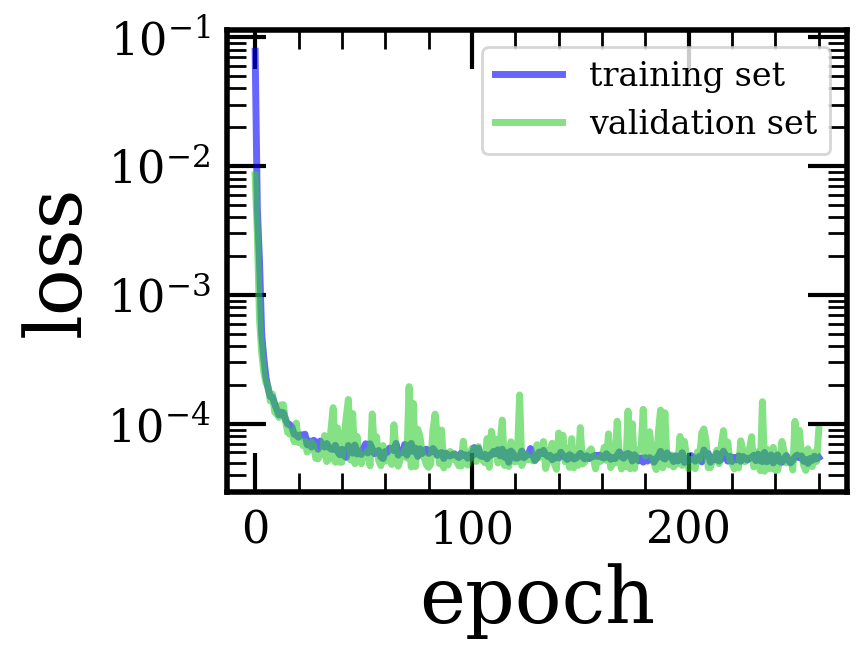

In [12]:
plotter.plot_loss(history_mean)

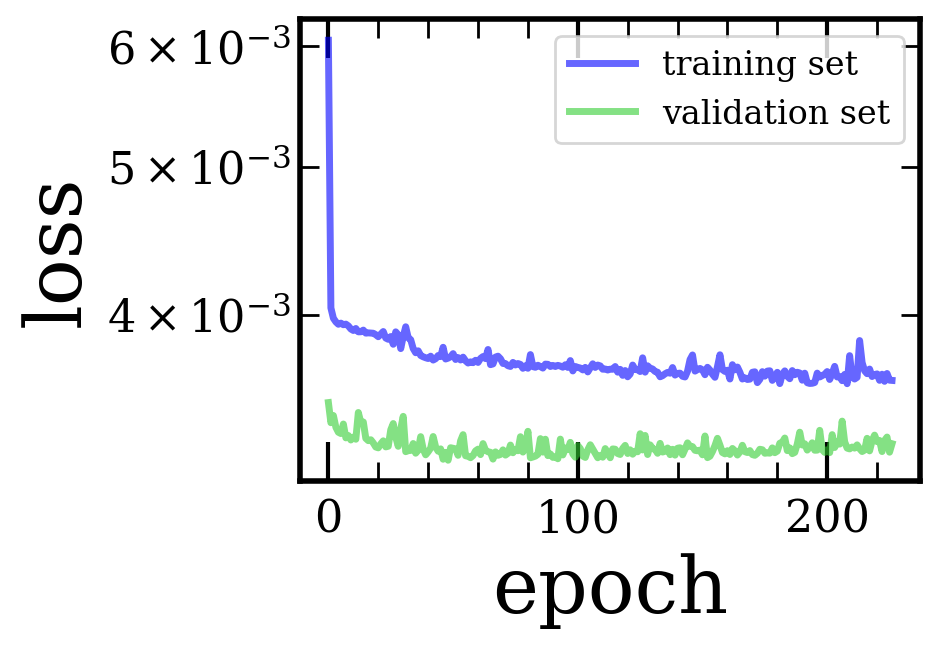

In [13]:
plotter.plot_loss(history_cov)

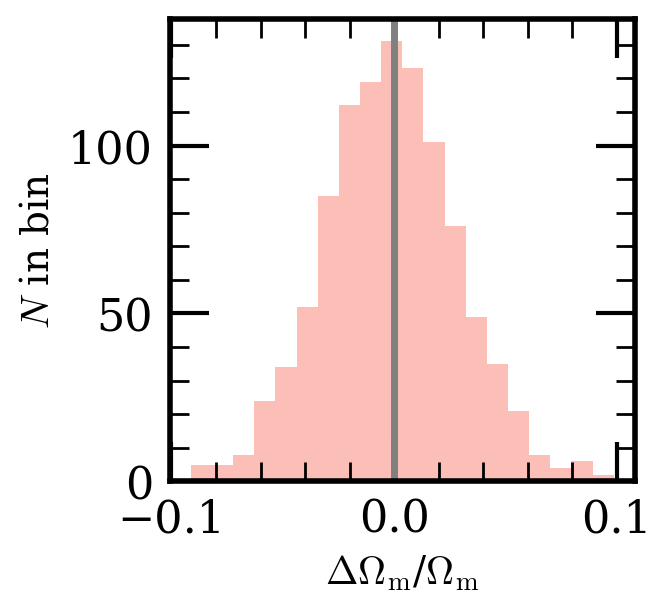

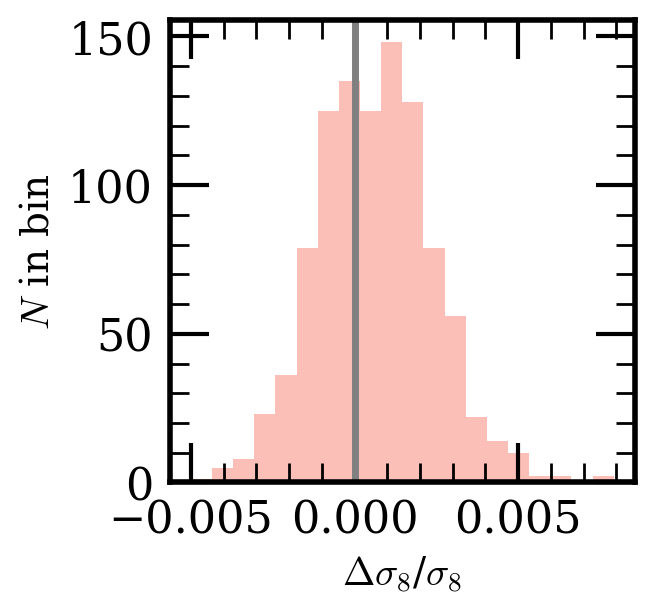

In [14]:
fracdiffs = (theta_test_pred - theta_test)/theta_test
plotter.plot_hists_mean(fracdiffs, param_labels)


/dipc/kstoreyf/muchisimocks/scripts/plotter.py:53: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(np.diag(cov_pred))


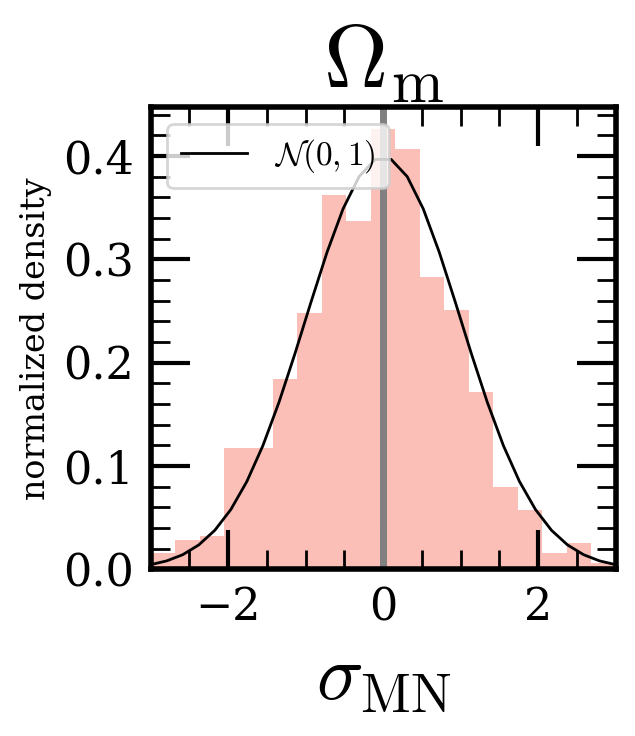

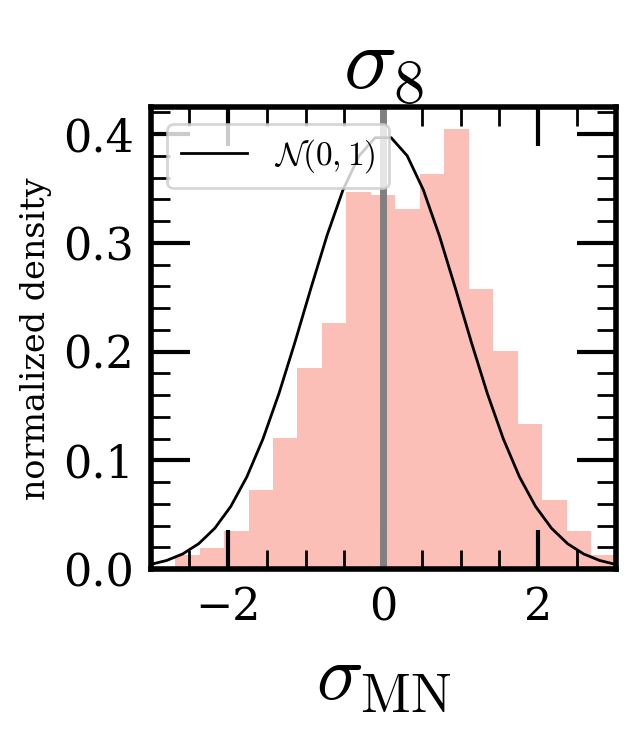

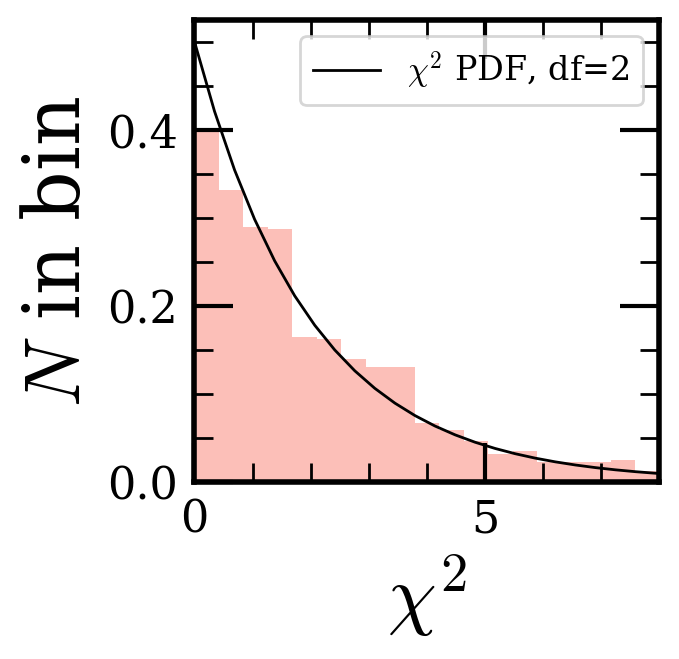

In [15]:
plotter.plot_hists_cov(theta_test, theta_test_pred, covs_test_pred, param_labels)

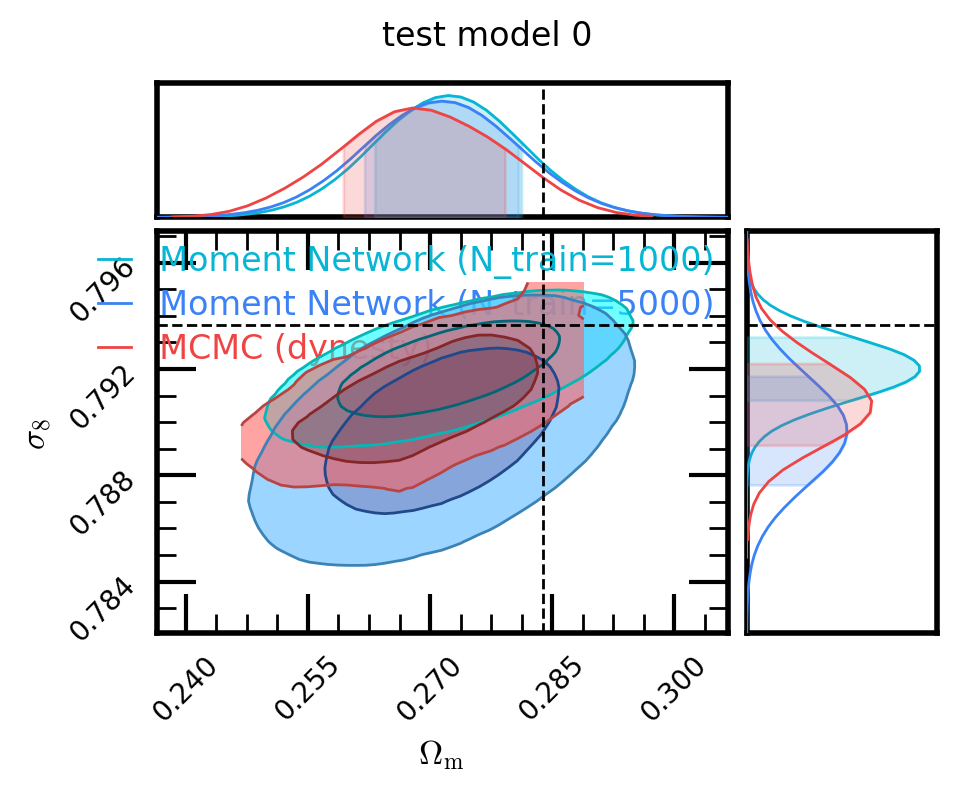

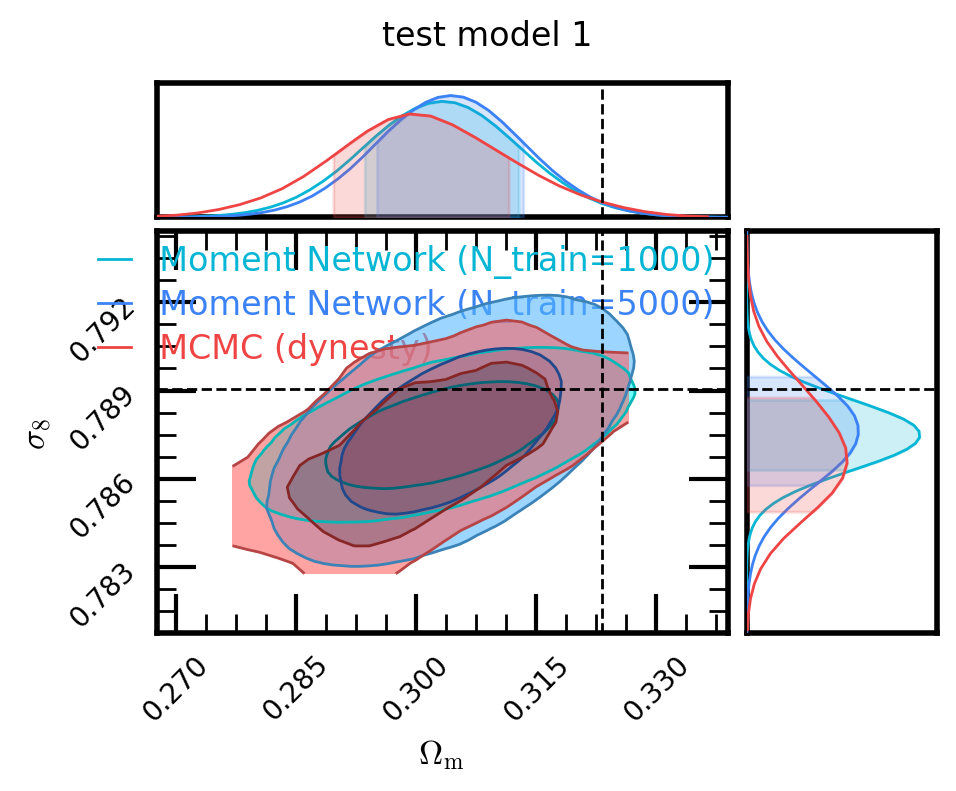

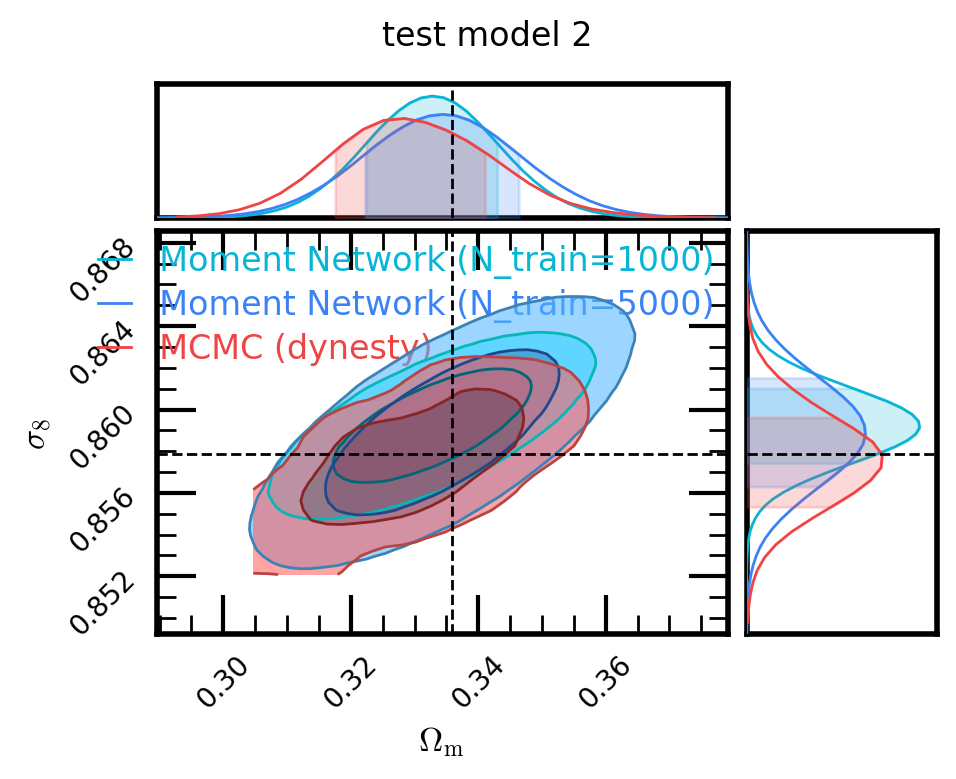

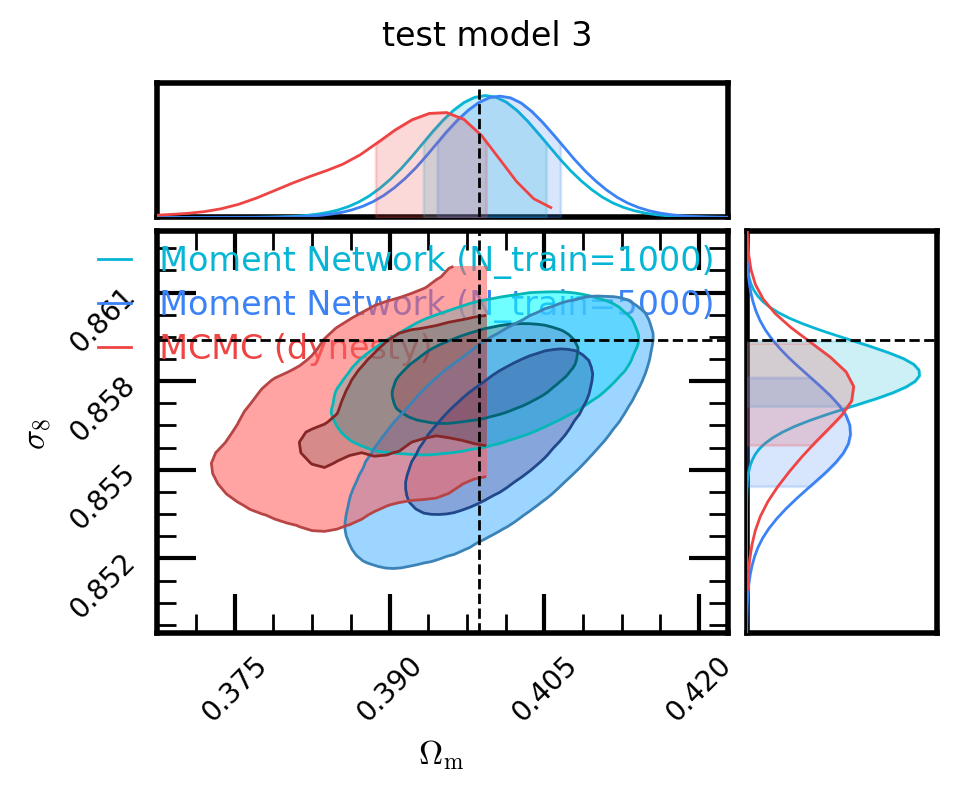

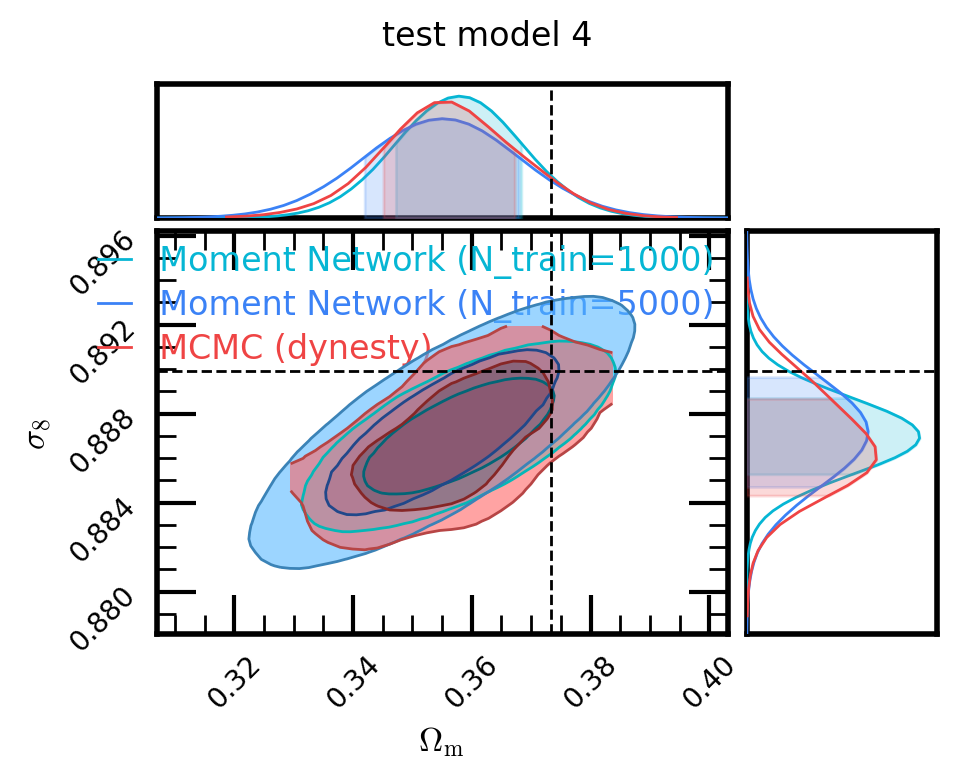

In [24]:
methods = ['mn', 'mn', 'dynesty']
#tags_inf = [tag_inf]*len(methods)
tags_inf = ['_emuPk_2param_boxsize500_ntrain5000',
            '_emuPk_2param_boxsize500_ntrain1000',
            '_emuPk_2param_boxsize500_ntrain5000']

labels_extra = ['(N_train=1000)', '(N_train=5000)', '']
colors = [utils.color_dict_methods[meth] for meth in methods]
colors[0] = 'cyan'

for idx_obs in range(5):
    theta_obs_true = theta_test[idx_obs]
    plotter.plot_contours_inf(param_names, idx_obs, theta_obs_true, 
                            methods, tags_inf, 
                            colors=colors, labels_extra=labels_extra)

